<a href="https://colab.research.google.com/github/marcellinusc/production-oil-rate-prediction/blob/master/rnn-model-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv \
    -O /content/XM-18.csv

--2020-06-23 12:07:28--  https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142394 (139K) [text/plain]
Saving to: ‘/content/XM-18.csv’

/content/XM-18.csv  100%[===================>] 139.06K  --.-KB/s    in 0.04s   

2020-06-23 12:07:29 (3.34 MB/s) - ‘/content/XM-18.csv’ saved [142394/142394]



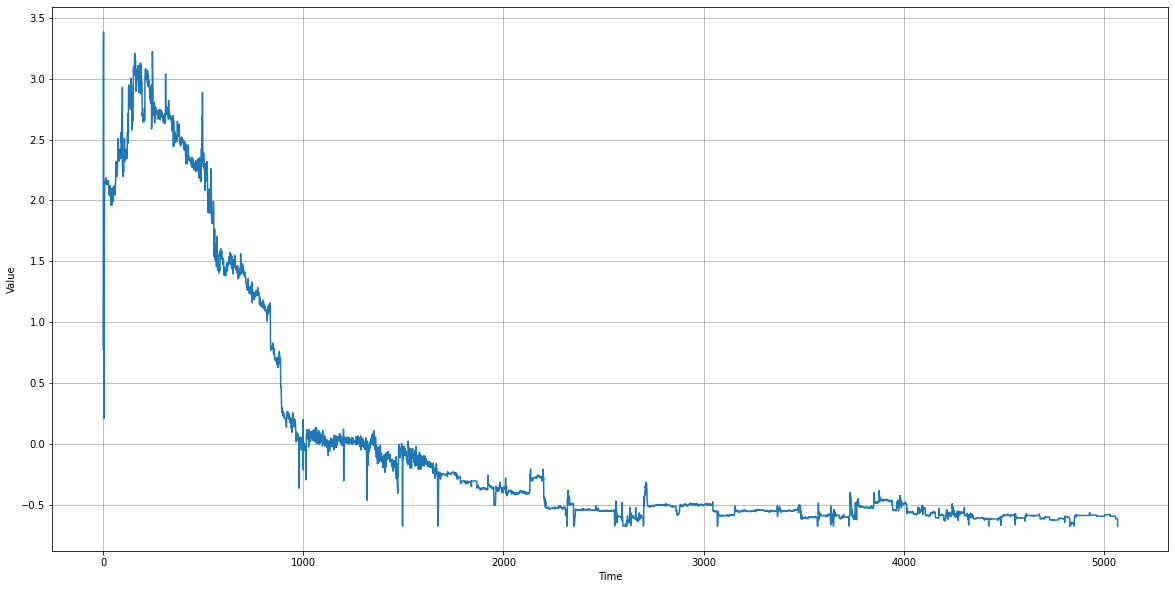

In [5]:
import csv
time_step = []
temps = []

with open('/content/XM-18.csv') as csvfile:
  # YOUR CODE HERE
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 10))
plot_series(time, series)

In [6]:
split_time = 4000
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
from keras import backend

def rmspe(y_true, y_pred):
    sum = backend.sqrt(backend.mean(backend.square( (y_true - y_pred) /
          backend.clip(backend.abs(y_true),backend.epsilon(),None) ), axis=-1) )
    return sum*100

Using TensorFlow backend.


In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4000,)
Epoch 1/100
16/16 [==============================] - 1s 57ms/step - loss: 2.0815 - lr: 1.0000e-08
Epoch 2/100
16/16 [==============================] - 1s 63ms/step - loss: 1.8730 - lr: 1.1220e-08
Epoch 3/100
16/16 [==============================] - 1s 65ms/step - loss: 1.6429 - lr: 1.2589e-08
Epoch 4/100
16/16 [==============================] - 1s 69ms/step - loss: 1.4430 - lr: 1.4125e-08
Epoch 5/100
16/16 [==============================] - 1s 65ms/step - loss: 1.2741 - lr: 1.5849e-08
Epoch 6/100
16/16 [==============================] - 1s 61ms/step - loss: 1.1273 - lr: 1.7783e-08
Epoch 7/100
16/16 [==============================] - 1s 62ms/step - loss: 1.0058 - lr: 1.9953e-08
Epoch 8/100
16/16 [==============================] - 1s 64ms/step - loss: 0.9188 - lr: 2.2387e-08
Epoch 9/100
16/16 [==============================] - 1s 63ms/step - loss: 0.8673 - lr: 2.5119e-08
Epoch 10/100
16/

(1e-08, 0.0001, 0.0, 2.0)

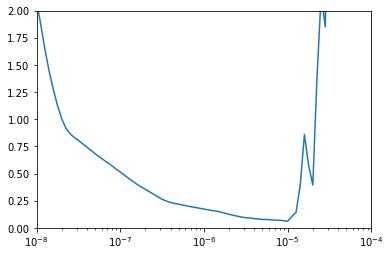

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape", rmspe])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE

# EXPECTED OUTPUT 
# You should see an MAE of <2 within about 30 epochs

Epoch 1/150
40/40 [==============================] - 1s 34ms/step - loss: 1.7158 - mape: 1876.2845 - rmspe: 1876.2845
Epoch 2/150
40/40 [==============================] - 1s 34ms/step - loss: 0.2113 - mape: 427.1819 - rmspe: 427.1819
Epoch 3/150
40/40 [==============================] - 1s 34ms/step - loss: 0.0480 - mape: 225.1356 - rmspe: 225.1356
Epoch 4/150
40/40 [==============================] - 1s 35ms/step - loss: 0.0425 - mape: 227.9087 - rmspe: 227.9087
Epoch 5/150
40/40 [==============================] - 1s 35ms/step - loss: 0.0394 - mape: 211.1199 - rmspe: 211.1199
Epoch 6/150
40/40 [==============================] - 1s 35ms/step - loss: 0.0373 - mape: 204.2679 - rmspe: 204.2679
Epoch 7/150
40/40 [==============================] - 1s 35ms/step - loss: 0.0365 - mape: 213.1687 - rmspe: 213.1687
Epoch 8/150
40/40 [==============================] - 1s 35ms/step - loss: 0.0356 - mape: 203.3222 - rmspe: 203.3222
Epoch 9/150
40/40 [==============================] - 1s 33ms/step - lo

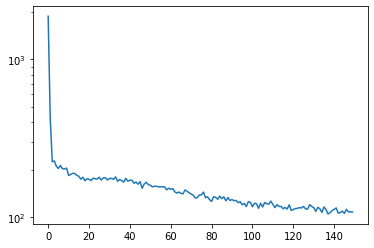

In [13]:
plt.semilogy(history.epoch, history.history["mape"])

In [14]:
# Save model as protobuf data format

model.save("saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/assets


In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

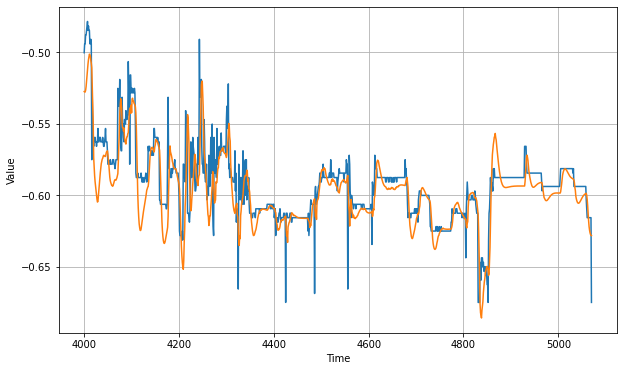

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT
# Plot should show projections following original data closely

In [17]:
def rmspe_pred(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

print("mape prediction:", tf.keras.metrics.mape(x_valid, rnn_forecast).numpy())
print("rmspe prediction:", rmspe_pred(x_valid, rnn_forecast))

mape prediction: 1.9161516
rmspe prediction: 2.8960677907909984


In [18]:
print(rnn_forecast)

# EXPECTED OUTPUT 
# Array of values in the low teens

[-0.5275729 -0.5278856 -0.5279092 ... -0.6273432 -0.6279708 -0.6281073]
